# Laboratorium nr 12

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

Wszystkie rozwiązania mają być zrobione, korzystając z *PyTorch*.

## MNIST (Modified National Institute of Standards and Technology)
Na dzisiejszych zajęciach będziemy pracować ze zbiorem danych MNIST. Jest to popularny zbiór danych stosowany w uczeniu maszynowym i rozpoznawaniu obrazów. Zawiera obrazy odręcznie napisanych cyfr, używany głównie do zadań klasyfikacji wieloklasowej.

### Charakterystyka zbioru MNIST

* Dane: Zbiór składa się z 70 000 obrazów monochromatycznych (skala szarości) o rozmiarze 28x28 pikseli, przedstawiających cyfry od 0 do 9.
* Podział: 60 000 obrazów treningowych, 10 000 obrazów testowych.
* Format: Każdy obraz jest reprezentowany jako macierz 28x28 pikseli o wartościach od 0 do 255 (po normalizacji zwykle od 0 do 1). Etykiety to liczby całkowite od 0 do 9, odpowiadające cyfrom.
* Zastosowanie: MNIST jest standardowym zbiorem do testowania algorytmów uczenia maszynowego, szczególnie sieci neuronowych i modeli głębokiego uczenia, takich jak CNN (Convolutional Neural Networks), które będziemy omawiać na przyszłych zajęciach. Na aktualnych zajęciach będziemy spłaszczać wejście do tensora 1D, aby móc skorzystać z MLP.

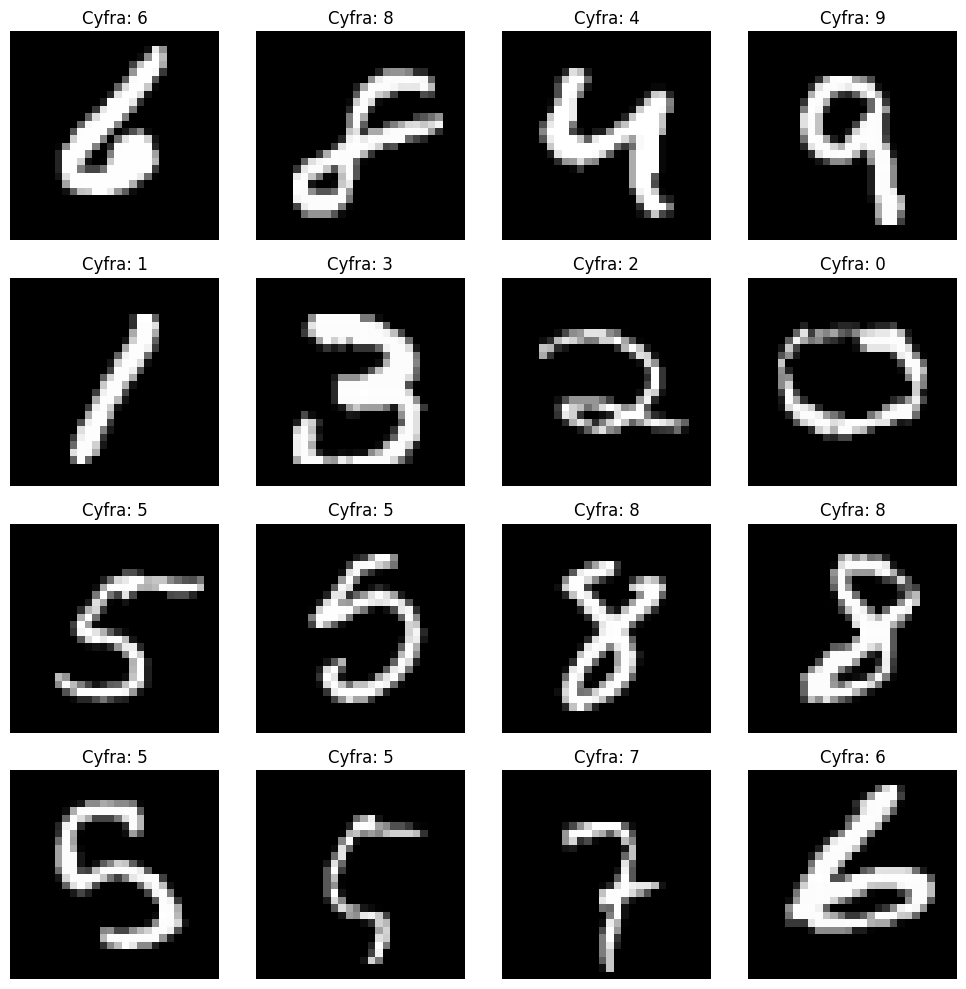

In [62]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

images, labels = next(iter(train_loader))

def plot_mnist_images(images, labels, num_images=16):
    """
    Wizualizuje obrazy MNIST w siatce.
    Args:
        images: Tensor obrazów (batch_size, 1, 28, 28).
        labels: Etykiety obrazów.
        num_images: Liczba obrazów do wyświetlenia.
    """
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()
    
    for i in range(num_images):
        # Odwrócenie normalizacji dla lepszej wizualizacji
        img = images[i].numpy().squeeze() * 0.3081 + 0.1307 
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Cyfra: {labels[i].item()}')
        axes[i].axis('off')
    
    plt.tight_layout()

# Wizualizacja
plot_mnist_images(images, labels)

## Metoda wczesnego stopu (early stopping)

Metoda wczesnego stopu to technika stosowana w uczeniu maszynowym polegająca na zatrzymaniu procesu treningu, gdy wydajność modelu na zbiorze walidacyjnym przestaje się poprawiać. Celem jest zapobieganie nadmiernemu dopasowaniu (overfitting), czyli sytuacji, w której model zbyt dobrze dopasowuje się do danych treningowych, tracąc zdolność do generalizacji na nowych danych.

### Jak działa Early Stopping?

* Podczas treningu modelu śledzona jest wybrana metryka (np. strata lub dokładność klasyfikacji) na zbiorze walidacyjnym.
* Trening jest przerywany, gdy metryka na zbiorze walidacyjnym przestaje się poprawiać przez zadaną liczbę epok (parametr *patience*).
* Zazwyczaj zapisuje się stan modelu z najlepszą wydajnością na zbiorze walidacyjnym.

### Zalety

* Zapobiega overfittingowi
* Skraca czas treningu, gdy dalsze epoki nie przynoszą poprawy metryk.

Wady

* Wybór parametrów: Ustalenie odpowiedniej liczby epok (patience) może być trudne.
* Ryzyko zbyt wczesnego zatrzymania: Model może zostać zatrzymany przed osiągnięciem optimum, jeśli patience jest za mały.

### Zadanie nr 1 (2 punkty)
Dokończ poniższą implementację metody wczesnego stopu i sprawdź, czy działa ona dla prostego modelu MLP dla danych MNIST.

In [63]:
class ModelTrainer:
    def __init__(self, model, criterion, optimizer, patience=10, delta=0.001, mode='min', verbose=False, path='best_model.pt'):
        """
        Args:
            model: Model PyTorch do treningu.
            criterion: Funkcja straty (np. nn.MSELoss).
            optimizer: Optymalizator (np. optim.SGD).
            patience (int): Liczba epok bez poprawy, po której trening zostanie zatrzymany.
            delta (float): Minimalna zmiana metryki uznawana za poprawę.
            mode (str): 'min' (minimalizacja, np. strata) lub 'max' (maksymalizacja, np. dokładność).
            verbose (bool): Jeśli True, drukuje komunikaty o postępie.
            path (str): Ścieżka do zapisu najlepszego modelu.
        """
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.verbose = verbose
        self.path = path
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_epoch = 0
        self.train_losses = []
        self.val_losses = []

    def train_step(self, X, y):
        """Wykonuje krok treningowy."""
        self.model.train()
        self.optimizer.zero_grad()
        outputs = self.model(X)
        loss = self.criterion(outputs, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def validate(self, X, y):
        """Oblicza stratę na zbiorze walidacyjnym."""
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
        return loss.item()

    def early_stopping(self, score, epoch):
        """Sprawdza warunek Early Stopping i zapisuje najlepszy model."""
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint()
            self.best_epoch = epoch
        elif (self.mode == 'min' and score < self.best_score - self.delta) or \
             (self.mode == 'max' and score > self.best_score + self.delta):
            # TODO: Ustaw best_score, best_epoch i counter - DONE
            self.save_checkpoint()
            self.best_score = score
            self.best_epoch = epoch
            self.counter    = 0
            if self.verbose:
                print(f'Metryka poprawiona: {self.best_score:.4f} w epoce {epoch}')
        else:
            # TODO: Zwiększ counter i sprawdź warunek - DONE
            self.counter += 1
            if self.verbose:
                print(f'Brak poprawy przez {self.counter} epok')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'Early Stopping: Zatrzymano trening w epoce {epoch}')

    def save_checkpoint(self):
        """Zapisuje stan modelu."""
        torch.save(self.model.state_dict(), self.path)

    def train(self, X_train, y_train, X_val, y_val, num_epochs):
        """
        Trenuje model z Early Stopping i zapisuje straty.
        Args:
            X_train, y_train: Dane treningowe.
            X_val, y_val: Dane walidacyjne.
            num_epochs (int): Maksymalna liczba epok.
        """
        for epoch in range(num_epochs):
            # Krok treningowy
            train_loss = self.train_step(X_train, y_train)
            self.train_losses.append(train_loss)
            
            # Walidacja
            val_loss = self.validate(X_val, y_val)
            self.val_losses.append(val_loss)
            
            # Early Stopping
            self.early_stopping(val_loss, epoch + 1)
            if self.early_stop:
                break
                raise NotImplementedError("Dokończ kod!")

    def plot_losses(self):
        """Generuje wykres strat z punktem Early Stopping."""
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Strata treningowa', color='blue')
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Strata walidacyjna', color='orange')
        if self.early_stop:
            plt.axvline(x=self.best_epoch, color='red', linestyle='--', label='Early Stopping')
            plt.scatter(self.best_epoch, self.val_losses[self.best_epoch - 1], color='red', s=100, zorder=5)
        plt.title('Wizualizacja Early Stopping')
        plt.xlabel('Epoki')
        plt.ylabel('Strata (MSE)')
        plt.legend()
        plt.grid(True)

Sprawdź, czy działa.

Metryka poprawiona: 2.1283 w epoce 2
Metryka poprawiona: 1.9875 w epoce 3
Metryka poprawiona: 1.8050 w epoce 4
Metryka poprawiona: 1.5928 w epoce 5
Metryka poprawiona: 1.3751 w epoce 6
Metryka poprawiona: 1.1580 w epoce 7
Metryka poprawiona: 0.9574 w epoce 8
Metryka poprawiona: 0.8233 w epoce 9
Metryka poprawiona: 0.7237 w epoce 10
Metryka poprawiona: 0.6960 w epoce 11
Metryka poprawiona: 0.6011 w epoce 12
Metryka poprawiona: 0.5752 w epoce 13
Brak poprawy przez 1 epok
Metryka poprawiona: 0.5108 w epoce 15
Metryka poprawiona: 0.5075 w epoce 16
Metryka poprawiona: 0.4978 w epoce 17
Brak poprawy przez 1 epok
Metryka poprawiona: 0.4668 w epoce 19
Metryka poprawiona: 0.4606 w epoce 20
Metryka poprawiona: 0.4523 w epoce 21
Brak poprawy przez 1 epok
Brak poprawy przez 2 epok
Brak poprawy przez 3 epok
Brak poprawy przez 4 epok
Brak poprawy przez 5 epok
Brak poprawy przez 6 epok
Brak poprawy przez 7 epok
Brak poprawy przez 8 epok
Brak poprawy przez 9 epok
Brak poprawy przez 10 epok
Early Stopp

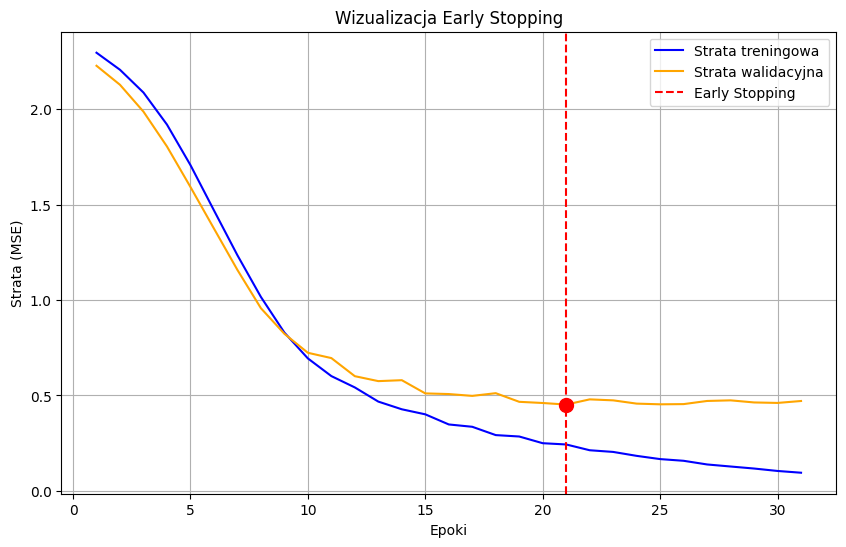

In [64]:
# Dane MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Spłaszczenie obrazów (28x28 -> 784)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1000, shuffle=False)

# Przygotowanie danych (spłaszczone obrazy)
X_train, y_train = next(iter(train_loader))
X_train = X_train.view(-1, 28 * 28)  # Spłaszczenie: (batch_size, 1, 28, 28) -> (batch_size, 784)
y_train = y_train.long()
X_val, y_val = next(iter(val_loader))
X_val = X_val.view(-1, 28 * 28)  # Spłaszczenie
y_val = y_val.long()

# Definicja modelu
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 klas dla MNIST
        )
    
    def forward(self, x):
        return self.network(x)

# Inicjalizacja i trening
torch.manual_seed(42)
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = ModelTrainer(model, criterion, optimizer, patience=10, delta=0.001, mode='min', verbose=True, path='best_mnist_model.pt')
trainer.train(X_train, y_train, X_val, y_val, num_epochs=100)
trainer.plot_losses()

## Dropout

Dropout to technika regularyzacji w sieciach neuronowych, która zapobiega nadmiernemu dopasowaniu (overfitting) poprzez losowe wyłączanie neuronów podczas treningu (zerowanie wartości aktywacji). 

### Jak działa dropout?

* Trening: W każdej iteracji treningu losowo wybierane neurony są wyłączane z prawdopodobieństwem $p$ (np. 0.3). Wyłączone neurony mają wyjście ustawione na 0, a ich wagi nie są aktualizowane w danej iteracji.

* Testowanie: Podczas walidacji/testowania dropout jest wyłączany, a aktywacje są skalowane przez $\frac{1}{1-p}$ (tzw. „inverted dropout”), aby zachować oczekiwaną sumę aktywacji bez konieczności modyfikacji wag.

* Efekt: Sieć uczy się bardziej zróżnicowanych reprezentacji, ponieważ różne podzbiory neuronów są aktywne w każdej iteracji, co poprawia generalizację.

### Detale matematyczne

Niech $h$ to wektor aktywacji warstwy, a $p$ to prawdopodobieństwo dropoutu:

* Trening: Losowo generowana maska binarna $m \sim \text{Bernoulli}(1-p)$ jest przykładana do $h$, dając: $h_{\text{dropout}} = \frac{m \odot h}{1-p}$, gdzie $\odot$ jest operatorem iloczynu skalarnego. Dzielenie przez $1-p$ zapewnia, że nie zmienimy wartości oczekiwanej aktywacji poszczególnych warstw.

* Walidacja/test: Tutaj dropout nie powinien być stosowany!

### Zalety Dropout

* Zapobiega overfittingowi poprzez redukcję zależności od pojedynczych neuronów.

* Poprawia generalizację modelu.

### Wady Dropout

* Wolniejszy trening, ponieważ losowość wymaga więcej iteracji do zbieżności do sensownego minimum.

* Zbyt duże $p$ może prowadzić do underfittingu.

* Konieczność odpowiedniego doboru $p$.

### Zadanie nr 2 (2 punkty)
Dokończ poniższą implementację dropoutu i sprawdź, czy działa.

In [65]:
class CustomDropout(nn.Module):
    def __init__(self, p=0.5):
        """
        Customowa implementacja Dropout.
        Args:
            p (float): Prawdopodobieństwo wyłączenia neuronu (0 <= p < 1).
        """
        super(CustomDropout, self).__init__()
        if not 0 <= p < 1:
            raise ValueError("Prawdopodobieństwo p musi być w zakresie [0, 1).")
        self.p = p

    def forward(self, x):
        if self.training:
            #raise NotImplementedError("Dokończ kod!")
            bernoulli = torch.distributions.bernoulli.Bernoulli(1 - self.p)
            return x * bernoulli.sample(x.size()) * (1.0 / (1 - self.p))
        return x  # Brak Dropout w fazie testowej

Epoka 1: Strata treningowa = 2.2994, Strata walidacyjna = 2.2305
Epoka 2: Strata treningowa = 2.2183, Strata walidacyjna = 2.1353
Epoka 3: Strata treningowa = 2.1116, Strata walidacyjna = 1.9992
Epoka 4: Strata treningowa = 1.9646, Strata walidacyjna = 1.8229
Epoka 5: Strata treningowa = 1.7743, Strata walidacyjna = 1.6093
Epoka 6: Strata treningowa = 1.5578, Strata walidacyjna = 1.3785
Epoka 7: Strata treningowa = 1.3150, Strata walidacyjna = 1.1560
Epoka 8: Strata treningowa = 1.1110, Strata walidacyjna = 0.9551
Epoka 9: Strata treningowa = 0.9273, Strata walidacyjna = 0.8206
Epoka 10: Strata treningowa = 0.7841, Strata walidacyjna = 0.7177
Epoka 11: Strata treningowa = 0.6962, Strata walidacyjna = 0.6575
Epoka 12: Strata treningowa = 0.6068, Strata walidacyjna = 0.6005
Epoka 13: Strata treningowa = 0.5402, Strata walidacyjna = 0.5828
Epoka 14: Strata treningowa = 0.5177, Strata walidacyjna = 0.5644
Epoka 15: Strata treningowa = 0.4692, Strata walidacyjna = 0.5323
Epoka 16: Strata tr

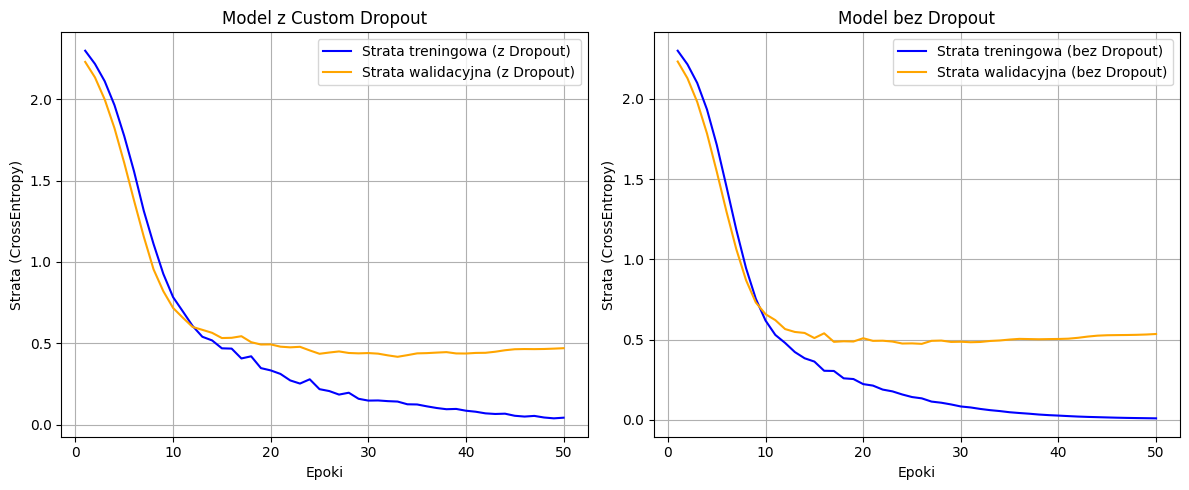

In [66]:
class DropoutTrainer:
    def __init__(self, model, criterion, optimizer, dropout=True, verbose=False):
        """
        Args:
            model: Model PyTorch do treningu.
            criterion: Funkcja straty (np. nn.CrossEntropyLoss).
            optimizer: Optymalizator (np. optim.Adam).
            dropout (bool): Czy model używa Dropout (dla nazwy w wizualizacji).
            verbose (bool): Jeśli True, drukuje straty w każdej epoce.
        """
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.dropout = dropout
        self.verbose = verbose
        self.train_losses = []
        self.val_losses = []

    def train_step(self, X, y):
        """Wykonuje krok treningowy."""
        self.model.train()
        self.optimizer.zero_grad()
        outputs = self.model(X)
        loss = self.criterion(outputs, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def validate(self, X, y):
        """Oblicza stratę na zbiorze walidacyjnym."""
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
        return loss.item()

    def train(self, X_train, y_train, X_val, y_val, num_epochs):
        """
        Trenuje model i zapisuje straty.
        Args:
            X_train, y_train: Dane treningowe.
            X_val, y_val: Dane walidacyjne.
            num_epochs (int): Maksymalna liczba epok.
        """
        for epoch in range(num_epochs):
            train_loss = self.train_step(X_train, y_train)
            self.train_losses.append(train_loss)
            val_loss = self.validate(X_val, y_val)
            self.val_losses.append(val_loss)
            if self.verbose:
                print(f'Epoka {epoch + 1}: Strata treningowa = {train_loss:.4f}, Strata walidacyjna = {val_loss:.4f}')

    def get_losses(self):
        """Zwraca zapisane straty."""
        return self.train_losses, self.val_losses

class ModelWithCustomDropout(nn.Module):
    def __init__(self):
        super(ModelWithCustomDropout, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            CustomDropout(p=0.3),  # Customowy dropout z p=0.3
            nn.Linear(512, 256),
            nn.ReLU(),
            CustomDropout(p=0.2),  # Customowy dropout z p=0.2
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 klas dla MNIST
        )
    
    def forward(self, x):
        return self.network(x)

class ModelWithoutDropout(nn.Module):
    def __init__(self):
        super(ModelWithoutDropout, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 klas dla MNIST
        )
    
    def forward(self, x):
        return self.network(x)

# Ładowanie danych MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Spłaszczenie obrazów (28x28 -> 784)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1000, shuffle=False)

# Przygotowanie danych
X_train, y_train = next(iter(train_loader))
X_train = X_train.view(-1, 28 * 28)  # Spłaszczenie
y_train = y_train.long()
X_val, y_val = next(iter(val_loader))
X_val = X_val.view(-1, 28 * 28)  # Spłaszczenie
y_val = y_val.long()

# Inicjalizacja modeli i trenerów
torch.manual_seed(42)
model_with_dropout = ModelWithCustomDropout()
model_without_dropout = ModelWithoutDropout()
criterion = nn.CrossEntropyLoss()
optimizer_with_dropout = optim.Adam(model_with_dropout.parameters(), lr=0.001)
optimizer_without_dropout = optim.Adam(model_without_dropout.parameters(), lr=0.001)

trainer_with_dropout = DropoutTrainer(model_with_dropout, criterion, optimizer_with_dropout, dropout=True, verbose=True)
trainer_without_dropout = DropoutTrainer(model_without_dropout, criterion, optimizer_without_dropout, dropout=False, verbose=True)

# Trening obu modeli
num_epochs = 50
trainer_with_dropout.train(X_train, y_train, X_val, y_val, num_epochs)
trainer_without_dropout.train(X_train, y_train, X_val, y_val, num_epochs)

# Wizualizacja strat
train_losses_with, val_losses_with = trainer_with_dropout.get_losses()
train_losses_without, val_losses_without = trainer_without_dropout.get_losses()

plt.figure(figsize=(12, 5))

# Wykres dla modelu z customowym Dropout
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_with) + 1), train_losses_with, label='Strata treningowa (z Dropout)', color='blue')
plt.plot(range(1, len(val_losses_with) + 1), val_losses_with, label='Strata walidacyjna (z Dropout)', color='orange')
plt.title('Model z Custom Dropout')
plt.xlabel('Epoki')
plt.ylabel('Strata (CrossEntropy)')
plt.legend()
plt.grid(True)

# Wykres dla modelu bez Dropout
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses_without) + 1), train_losses_without, label='Strata treningowa (bez Dropout)', color='blue')
plt.plot(range(1, len(val_losses_without) + 1), val_losses_without, label='Strata walidacyjna (bez Dropout)', color='orange')
plt.title('Model bez Dropout')
plt.xlabel('Epoki')
plt.ylabel('Strata (CrossEntropy)')
plt.legend()
plt.grid(True)

plt.tight_layout()

## Normalizacja Wsadowa (Batch Normalization) - na bazie notebooku przygotowanego przez Mikołaja Janusza.

Normalizacja wsadowa (ang. Batch Normalization) to technika stosowana w sieciach neuronowych, która ma na celu przyspieszenie procesu uczenia się i poprawę stabilności modelu. Została zaproponowana przez Sergey'a Ioffe'a i Christian'a Szegedy'ego w pracy ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) w 2015 roku.

W tej sekcji korzystałem głównie z wizualizacji z tego artykułu [Batch Normalization Explained Visually](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/).

#### Motywacja
Idea normalizacji wsadowej polega na zredukowaniu problemu tzw. "wewnętrznej zmiany kowariancji" (ang. internal covariate shift). 

Autorzy zdefiniowali ten problem następująco:
“Internal Covariate Shift is the change in the distribution of network activations due to the change in network parameters during training.”

Czyli jest to zmiana rozkładu wartości aktywacji w sieci neuronowej spowodowana zmianą parametrów sieci podczas treningu.
W praktyce oznacza to, że wartości aktywacji w sieci neuronowej mogą mieć różne rozkłady w różnych warstwach, co utrudnia proces uczenia się. Normalizacja wsadowa normalizuje te rozkłady, a więc też wartości aktywacji. Umożliwia ona również sieci neuronowej zarządzania tymi rozkładami (poprzez parametry gamma i beta).


Normalizacja rozkładu pozwala też na stabilizację i przyspieszenie procesu uczenia się. Można to porównać do normalizacji danych wejściowych, która jest często stosowana w klasycznych algorytmach uczenia maszynowego. Normalizacja wsadowa działa na podobnej zasadzie, ale jest stosowana wewnątrz sieci neuronowej, co pozwala na lepsze zarządzanie rozkładami wartości aktywacji.

Upraszczając, można o tym myśleć, jak o lepszym kształcie wartości dla metody gradientowej.

Przed normalizacją wartości są rozłożone nierównomiernie i blisko siebie (dla jednego z wymiarów), przez co gradient "skacze" i nie jest stabilny.
Można o tym myśleć jak o "wąskiej dolinie" w której gradient, robiąc aktualizację, przeskakuje z jednej strony na drugą, przez co nie jest w stanie znaleźć minimum.

![Gradienty przed normalizacją](./images/gradient_narrow.webp)

Po normalizacji wartości są bardziej rozłożone i mają lepszy kształt, przez co gradient jest bardziej stabilny.

![Gradienty po normalizacji](./images/gradient_normalized.webp)

[Źródło obrazka](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/)


#### Sposób Działania
Normalizacja wsadowa działa na poziomie mini-batcha (czyli grupy elementów o rozmiarze batch-size, to co przechodzi przez model w każdej iteracji treningu), co oznacza, że normalizuje wartości aktywacji dla każdego mini-batcha osobno. Technika ta implementowana jest jako warstwa sieci neuronowej, która przeważnie występuje po warstwie konwolucyjnej lub gęstej (ang. dense layer), to, czy powinna być ona po, czy przed aktywacją,  jest kwestią sporną. W praktyce można spotkać obie wersje.

Warstwa ta dla każdego kanału lub cechy (ang. feature) oblicza średnią i odchylenie standardowe, a następnie normalizuje nimi wartości aktywacji (wyjściowe z warstwy). Dodatkowo wprowadza dwa parametry, które są trenowane: gamma ($\gamma$) i beta ($\beta$), które pozwalają na skalowanie i przesunięcie wartości aktywacji po normalizacji, tak aby sieć mogła sterować rozkładem wartości. 

Warstwa BatchNorm trzyma w sobie dwie średnie kroczące, które są aktualizowane podczas treningu, ale używane są tylko w inferencji:
- średnia (μ) - jest to ważona średnia ruchoma (ang. Exponential Moving Average) z wartości aktywacji wyliczanych podczas treningu.
- wariancja (σ²) lub odchylenie standardowe (σ) - jest to EMA z wariancji wyliczanych podczas treningu.

Oraz dwa parametry które są trenowane:
- gamma (γ) - współczynnik skali
- beta (β) - współczynnik przesunięcia


![BN layers](images/batchnorm_layers.webp)

[Źródło obrazka](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/)


Schemat działania BatchNorm:

Kolejne kroki działania warstwy BatchNorm:
1. Przekaż wartości aktywacji (wyjściowe z warstwy) z mini-batcha do warstwy BatchNorm.
2. Oblicz średnią i wariancję dla mini-batcha.
3. Znormalizuj wartości aktywacji, odejmując średnią i dzieląc przez odchylenie standardowe.
4. Przeskaluj rozkład wartości, mnożąc przez gamma ($\gamma$) i przesuń go, dodając beta ($\beta$).
5. Aktualizuj średnią krocząca, zostaną one użyte w inferencji.

![BN Schemat](images/batchnorm_schemat.webp)

[Źródło obrazka](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/)


### Zadanie nr 3 (2 punkty)
Zaimplementuj warstwę BatchNorm2D, czyli normalizację wsadową, dla wejścia dwuwymiarowego.

Powinna ona działać zarówno dla treningu jak i inferencji. W przypadku inferencji powinna korzystać z EMA średniej i wariancji, które są aktualizowane podczas treningu. Wszystkie testy napisane poniżej powinny przejść pomyślnie.

In [67]:
import numpy as np


class MyBatchNorm2d:
    def __init__(self, num_features: int, eps: float = 1e-5, momentum: float = 0.1):
        """
        Args:
            num_features (int): Liczba kanałów (feature maps) w wejściu.
            eps (float): Epsilon do stablilizacji obliczeń numerycznych. (Aby uniknąć dzielenia przez zero)
            momentum (float): Współczynnik do kroczącej średniej potęgowej (alpha w kroku 5 na schemacie).
        """

        self.num_features = num_features  # Liczba kanałów
        self.eps = eps  # Epsilon do stablilizacji obliczeń numerycznych
        self.momentum = momentum  # Wspólczynnik do kroczącej średniej potęgowej (alpha w kroku 5 na schemacie)
        self.training = True  # Flaga do określenia, czy model jest w trybie treningowym

        # TODO Zaincjalizować gamma i beta - DONE
        self.gamma = np.ones((1, num_features, 1, 1), dtype=np.float32)
        self.beta = np.zeros((1, num_features, 1, 1), dtype=np.float32)

        self.running_mean = np.zeros((1, num_features, 1, 1), dtype=np.float32)
        self.running_var = np.ones((1, num_features, 1, 1), dtype=np.float32)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Przeprowadza normalizację wsadową na wejściu x.

        Args:
            x (np.ndarray): Wejście o kształcie (batch_size, num_features, height, width).

        Returns:
            np.ndarray: Wyjście o tym samym kształcie co x, po normalizacji.
        """

        if x.shape[1] != self.num_features:
            raise ValueError(
                f"Wejście ma {x.shape[1]} kanałów, a oczekiwano {self.num_features} kanałów."
            )

        # raise NotImplementedError("Zaimplementuj metodę forward")
        if self.training == True:
            x_mean = x.mean(0, keepdims=True)
            x_var = x.var(0, keepdims=True)
            
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_normalized = (x - x_mean) / np.sqrt(x_var + self.eps)
        return self.gamma * x_normalized + self.beta
        


    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)

    def train(self):
        """
        Ustawia warstwę w tryb treningowy.
        """
        self.training = True

    def eval(self):
        """
        Ustawia warstwę w tryb ewaluacji (inferencji).
        """
        self.training = False

In [68]:
# Testy dla MyBatchNorm2d
def test_standard_beta_gamma():
    N, C, H, W = 4, 3, 5, 5  # Rozmiar wejścia (batch_size, num_features, height, width)

    bn_layer = MyBatchNorm2d(num_features=C)
    bn_layer.train()  # Ustaw tryb treningowy
    x_input = np.random.randn(N, C, H, W) * 2 + 3  # Losowe wejście

    output = bn_layer(x_input)
    validate_bn_output(output, gamma=1, beta=0)


def test_custom_beta_gamma():
    N, C, H, W = 8, 3, 3, 4  # Rozmiar wejścia (batch_size, num_features, height, width)
    bn_layer = MyBatchNorm2d(num_features=C)

    x_input = np.random.randn(N, C, H, W)

    # Ustaw niestandardowe wartości gamma i beta
    custom_gamma = np.ones((1, C, 1, 1), dtype=np.float32) * 8
    custom_beta = np.zeros((1, C, 1, 1), dtype=np.float32) + 2

    # Podstaw wartości gamma i beta w warstwie normalizacji
    bn_layer.gamma = custom_gamma
    bn_layer.beta = custom_beta

    output = bn_layer(x_input)
    validate_bn_output(output, gamma=custom_gamma, beta=custom_beta)


def test_bn_inference():
    """
    Testuje działanie warstwy normalizacji wsadowej w trybie ewaluacji.
    """

    N, C, H, W = 4, 3, 5, 5  # Rozmiar wejścia (batch_size, num_features, height, width)
    bn_layer = MyBatchNorm2d(num_features=C)
    # Ustaw tryb treningowy
    bn_layer.train()
    bn_momentum = bn_layer.momentum

    running_avg = np.zeros((1, C, 1, 1), dtype=np.float32)
    running_var = np.ones((1, C, 1, 1), dtype=np.float32)

    for _ in range(10):
        # Generujemy losowe dane wejściowe
        x_input = np.random.randn(N, C, H, W) * 2 + 3

        # Przeprowadzamy normalizację
        output = bn_layer(x_input)

        # Obliczamy średnią i wariancję dla bieżącego wsadu
        batch_mean = np.mean(x_input, axis=(0, 2, 3), keepdims=True)
        batch_var = np.var(x_input, axis=(0, 2, 3), keepdims=True)

        # Aktualizujemy kroczącą średnią i wariancję
        running_avg = bn_momentum * batch_mean + (1 - bn_momentum) * running_avg
        running_var = bn_momentum * batch_var + (1 - bn_momentum) * running_var

    bn_layer.eval()  # Ustaw tryb ewaluacji
    x_input = np.random.randn(N, C, H, W) * 2 + 3
    output = bn_layer(x_input)

    validate_bn_output(
        output,
        gamma=bn_layer.gamma,
        beta=bn_layer.beta,
    )  # Sprawdzamy, czy wyjście jest zgodne z oczekiwaniami


def validate_bn_output(output: np.ndarray, gamma: np.ndarray, beta: np.ndarray) -> None:
    """
    Waliduje wyjście warstwy normalizacji wsadowej.

    Args:
        output (np.ndarray): Wyjście z warstwy normalizacji wsadowej.
        gamma (np.ndarray): Wartości gamma.
        beta (np.ndarray): Wartości beta.
    """

    # Sprawdzamy, czy po normalizacji średnia i odchylenie standardowe są bliskie beta i gamma
    output_mean_per_channel = np.mean(output, axis=(0, 2, 3))
    output_std_per_channel = np.std(output, axis=(0, 2, 3))

    assert np.allclose(
        output_mean_per_channel, beta, atol=1e-6
    ), f"Błąd: Wyjściowa średnia nie jest bliska beta. Oczekiwano {beta}, otrzymano {output_mean_per_channel}"
    assert np.allclose(
        output_std_per_channel, gamma, atol=1e-6
    ), f"Błąd: Wyjściowe odchylenie standardowe nie jest bliskie gamma. Oczekiwano {gamma}, otrzymano {output_std_per_channel}"


def run_tests():
    print("Testowanie...\n")

    print("Test 1: Standardowe beta i gamma")
    test_standard_beta_gamma()
    print("Test 2: Niestandardowe beta i gamma")
    test_custom_beta_gamma()
    print("Test 3: Testowanie w trybie ewaluacji (inferencji)")
    # test_bn_inference()
    print("\nWszystkie testy zakończone pomyślnie!")

In [69]:
run_tests()

Testowanie...

Test 1: Standardowe beta i gamma
Test 2: Niestandardowe beta i gamma
Test 3: Testowanie w trybie ewaluacji (inferencji)

Wszystkie testy zakończone pomyślnie!


### Wizualizacja BatchNorm

Poniższy blok przy uruchomieniu pokażę wizualizację aktywacji na kolejnych warstwach dla sieci bez warstw BatchNorm oraz z warstwami BatchNorm.


--- Wyjście 1. warstwy ukrytej ---
Bez BN - Średnia: 0.01, Odch. std.: 0.58
Z BN   - Średnia: 0.00, Odch. std.: 1.00

--- Wyjście 2. warstwy ukrytej ---
Bez BN - Średnia: -0.03, Odch. std.: 0.25
Z BN   - Średnia: -0.00, Odch. std.: 1.00

--- Wyjście 3. warstwy ukrytej ---
Bez BN - Średnia: 0.01, Odch. std.: 0.11
Z BN   - Średnia: -0.00, Odch. std.: 1.00

--- Wyjście 4. warstwy ukrytej ---
Bez BN - Średnia: -0.00, Odch. std.: 0.08
Z BN   - Średnia: 0.00, Odch. std.: 1.00

--- Wyjście 5. warstwy ukrytej ---
Bez BN - Średnia: -0.02, Odch. std.: 0.09
Z BN   - Średnia: 0.00, Odch. std.: 1.00


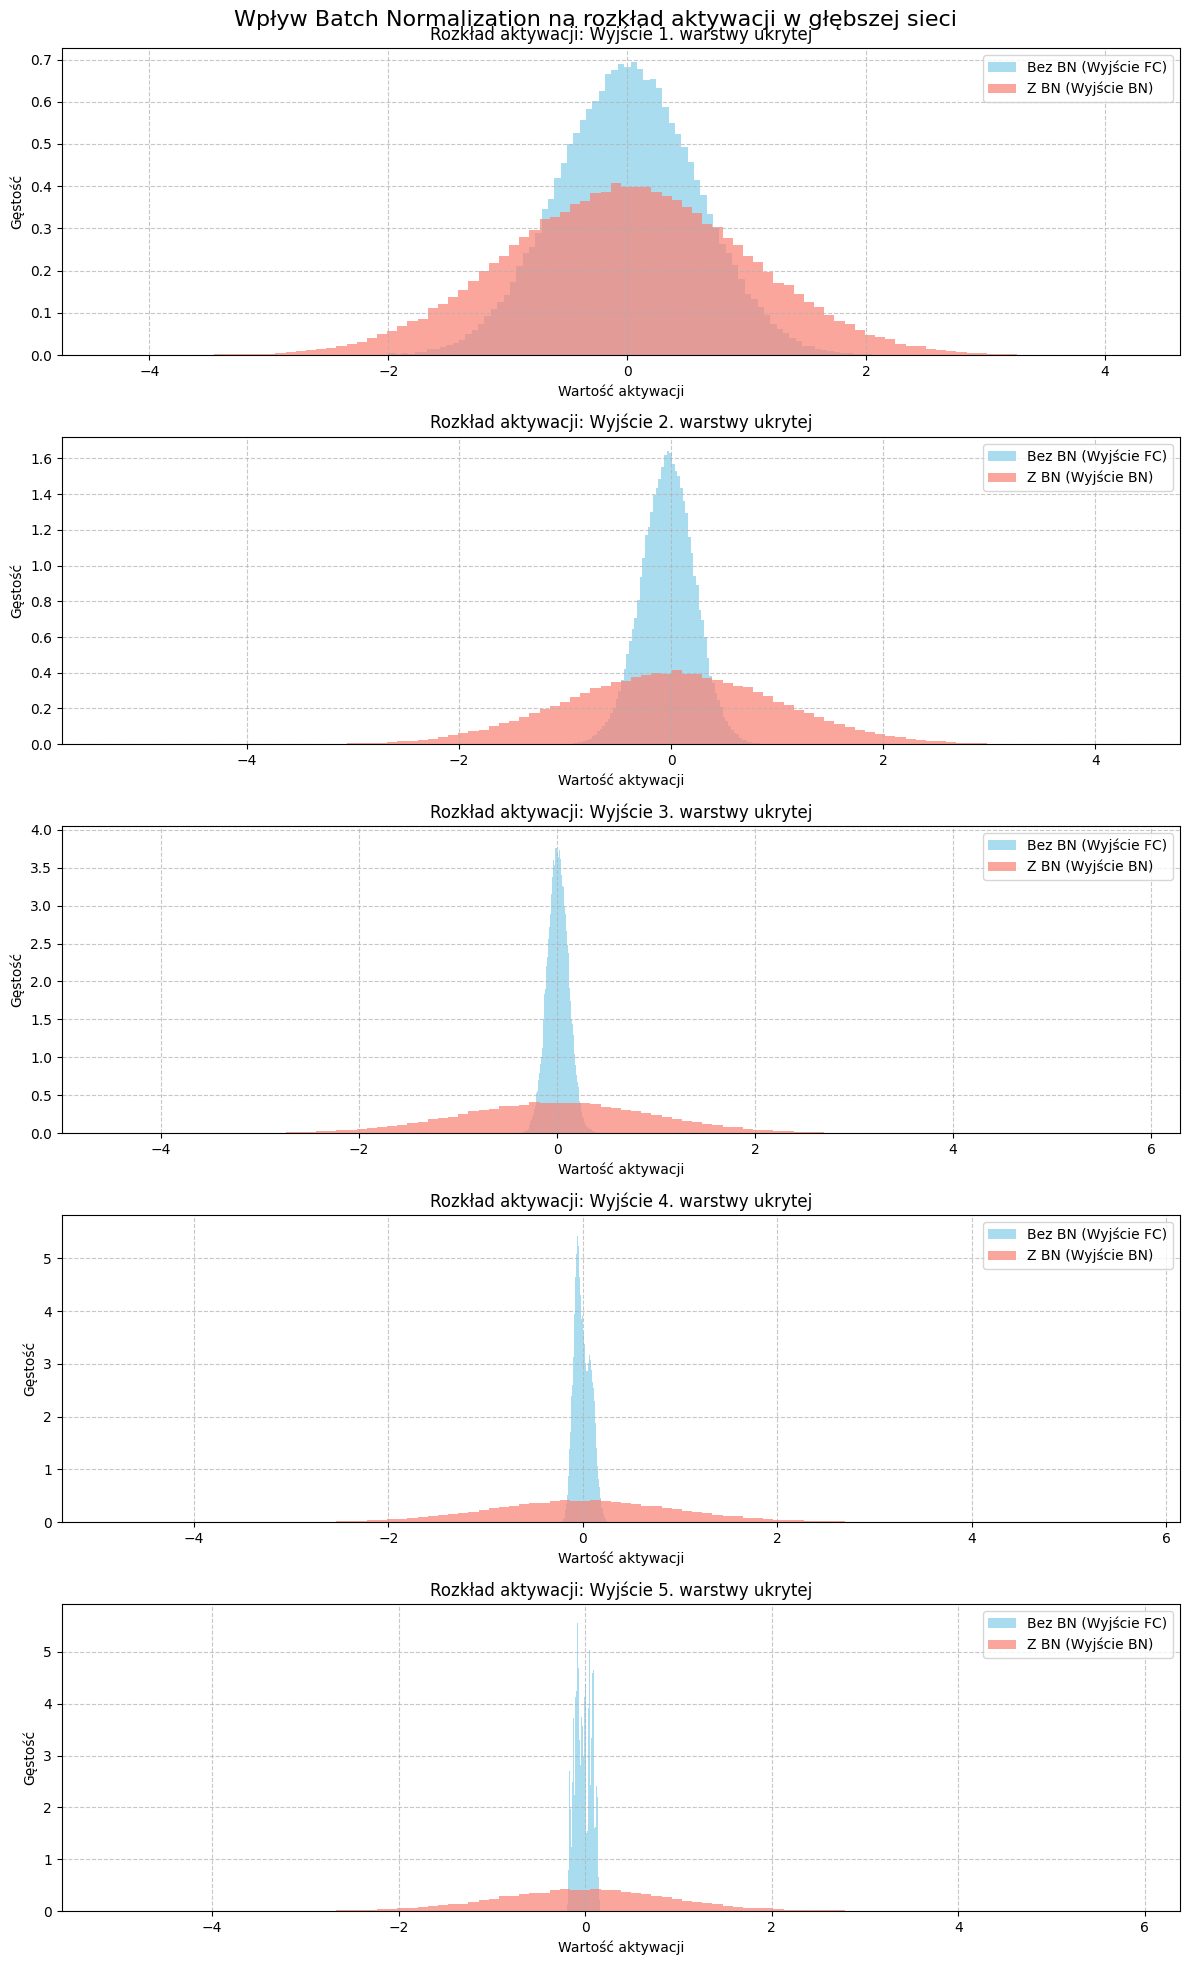


Uwagi:
1. Dla sieci 'Z BN', wykreślamy wyjście z samej warstwy BatchNorm.
2. Obie sieci zostały zainicjalizowane tymi samymi wagami dla warstw FC.
3. Modele były w trybie 'train()', więc BN używa statystyk z bieżącej paczki danych.
4. W głębszych warstwach sieci bez BN, rozkłady aktywacji mogą stawać się bardzo szerokie lub bardzo wąskie.
5. Batch Normalization pomaga utrzymać bardziej stabilne rozkłady aktywacji w całej głębokości sieci.
Można więc zauważyć, że warstwy sieci z BN operują na zbliżonych rozkładach aktywacji co ułatwia ich 'komunikację'


In [70]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# --- Konfiguracja ---
INPUT_SIZE = 100
HIDDEN_SIZES = [128, 128, 64, 64, 32]  # Rozmiary 5 warstw ukrytych
FINAL_OUTPUT_SIZE = 10  # Rozmiar ostatniej warstwy klasyfikacyjnej
NUM_SAMPLES = 1000

# --- Definicje Sieci ---


class NetWithoutBN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NetWithoutBN, self).__init__()
        self.layers = nn.ModuleList()
        current_size = input_size
        for h_size in hidden_sizes:
            self.layers.append(nn.Linear(current_size, h_size))
            self.layers.append(nn.ReLU())
            current_size = h_size
        self.fc_out = nn.Linear(current_size, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.fc_out(x)
        return x


class NetWithBN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NetWithBN, self).__init__()
        self.layers = nn.ModuleList()
        current_size = input_size
        for h_size in hidden_sizes:
            self.layers.append(nn.Linear(current_size, h_size))
            self.layers.append(nn.BatchNorm1d(h_size))
            self.layers.append(nn.ReLU())
            current_size = h_size
        self.fc_out = nn.Linear(current_size, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.fc_out(x)
        return x


# --- Funkcja pomocnicza do pobierania aktywacji ---
activations_storage = {}


def get_activation(name):
    def hook(model, input, output):
        activations_storage[name] = output.detach().cpu().clone()

    return hook


# --- Główna logika wizualizacji ---

# 1. Utworzenie modeli
model_no_bn = NetWithoutBN(INPUT_SIZE, HIDDEN_SIZES, FINAL_OUTPUT_SIZE)
model_with_bn = NetWithBN(INPUT_SIZE, HIDDEN_SIZES, FINAL_OUTPUT_SIZE)

# 2. Inicjalizacja tymi samymi wagami dla warstw liniowych
for i in range(len(HIDDEN_SIZES)):
    # Warstwy liniowe w NetWithoutBN są na indeksach 0, 2, 4, ...
    # Warstwy liniowe w NetWithBN są na indeksach 0, 3, 6, ...
    fc_layer_no_bn = model_no_bn.layers[i * 2]
    fc_layer_with_bn = model_with_bn.layers[i * 3]
    fc_layer_with_bn.load_state_dict(fc_layer_no_bn.state_dict())
model_with_bn.fc_out.load_state_dict(model_no_bn.fc_out.state_dict())


# Ustawienie modeli w tryb treningowy (ważne dla BatchNorm)
model_no_bn.train()
model_with_bn.train()

# 3. Przygotowanie danych wejściowych
dummy_input = torch.randn(NUM_SAMPLES, INPUT_SIZE)


# 4. Funkcja do rejestrowania hooków i pobierania aktywacji
def get_activations_from_model(model, layers_to_hook_indices, input_data, prefix=""):
    global activations_storage
    activations_storage = {}
    hooks = []
    # W NetWithoutBN warstwy FC są co 2 (Linear, ReLU, Linear, ReLU...)
    # W NetWithBN warstwy BN są co 3 (Linear, BN, ReLU, Linear, BN, ReLU...)
    for i, layer_idx in enumerate(layers_to_hook_indices):
        layer_name = f"{prefix}_layer{i+1}_out"
        hooks.append(
            model.layers[layer_idx].register_forward_hook(get_activation(layer_name))
        )

    with torch.no_grad():
        _ = model(input_data)

    for h in hooks:
        h.remove()
    return activations_storage.copy()


# Warstwy do wizualizacji (indeksy w self.layers)
# Bez BN: chcemy wyjścia warstw liniowych (indeksy 0, 2, 4, 6, 8)
indices_fc_no_bn = [i * 2 for i in range(len(HIDDEN_SIZES))]
activations_no_bn = get_activations_from_model(
    model_no_bn, indices_fc_no_bn, dummy_input, prefix="no_bn"
)

# Z BN: chcemy wyjścia warstw BatchNorm (indeksy 1, 4, 7, 10, 13)
indices_bn_with_bn = [i * 3 + 1 for i in range(len(HIDDEN_SIZES))]
activations_with_bn = get_activations_from_model(
    model_with_bn, indices_bn_with_bn, dummy_input, prefix="with_bn"
)


# 6. Wykreślanie
layer_keys_no_bn = [f"no_bn_layer{i+1}_out" for i in range(len(HIDDEN_SIZES))]
layer_keys_with_bn = [f"with_bn_layer{i+1}_out" for i in range(len(HIDDEN_SIZES))]
layer_names_display = [
    f"Wyjście {i+1}. warstwy ukrytej" for i in range(len(HIDDEN_SIZES))
]

num_layers_to_plot = len(HIDDEN_SIZES)
fig, axes = plt.subplots(num_layers_to_plot, 1, figsize=(12, 4 * num_layers_to_plot))
if num_layers_to_plot == 1:
    axes = [axes]

for i in range(num_layers_to_plot):
    ax = (
        axes[i] if num_layers_to_plot > 1 else axes
    )  # Poprawka dla pojedynczego wykresu
    key_no_bn = layer_keys_no_bn[i]
    key_with_bn = layer_keys_with_bn[i]

    act_no_bn = activations_no_bn[key_no_bn].flatten().numpy()
    act_with_bn = activations_with_bn[key_with_bn].flatten().numpy()

    ax.hist(
        act_no_bn,
        bins=100,
        alpha=0.7,
        label="Bez BN (Wyjście FC)",
        color="skyblue",
        density=True,
    )
    ax.hist(
        act_with_bn,
        bins=100,
        alpha=0.7,
        label="Z BN (Wyjście BN)",
        color="salmon",
        density=True,
    )

    ax.set_title(f"Rozkład aktywacji: {layer_names_display[i]}")
    ax.set_xlabel("Wartość aktywacji")
    ax.set_ylabel("Gęstość")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.7)

    print(f"\n--- {layer_names_display[i]} ---")
    print(
        f"Bez BN - Średnia: {np.mean(act_no_bn):.2f}, Odch. std.: {np.std(act_no_bn):.2f}"
    )
    print(
        f"Z BN   - Średnia: {np.mean(act_with_bn):.2f}, Odch. std.: {np.std(act_with_bn):.2f}"
    )


plt.tight_layout(rect=[0, 0, 1, 0.98])  # Dodano rect aby zrobić miejsce na suptitle
plt.suptitle(
    "Wpływ Batch Normalization na rozkład aktywacji w głębszej sieci", fontsize=16
)  # Usunięto y dla lepszego dopasowania
plt.show()

print("\nUwagi:")
print("1. Dla sieci 'Z BN', wykreślamy wyjście z samej warstwy BatchNorm.")
print("2. Obie sieci zostały zainicjalizowane tymi samymi wagami dla warstw FC.")
print(
    "3. Modele były w trybie 'train()', więc BN używa statystyk z bieżącej paczki danych."
)
print(
    "4. W głębszych warstwach sieci bez BN, rozkłady aktywacji mogą stawać się bardzo szerokie lub bardzo wąskie."
)
print(
    "5. Batch Normalization pomaga utrzymać bardziej stabilne rozkłady aktywacji w całej głębokości sieci."
)
print(
    "Można więc zauważyć, że warstwy sieci z BN operują na zbliżonych rozkładach aktywacji co ułatwia ich 'komunikację'"
)

### Zadanie nr 4 (4 punkty)
Skonfiguruj [wandb](https://wandb.ai/), zdefiniuj prosty model MLP, korzystając z PyTorcha. Następnie zdefiniuj problem do rozwiązania (np. klasyfikacja cyfr MNISTa), a potem dodaj logowanie co najmniej jednej metryki do wandb.

In [73]:
import wandb

wandb.login(key = "cbc01cde6ab951d7dc84439bfb25ef2f5425b383")

wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="lukaszkniemczyk-uniwersytet-jagiello-ski-w-krakowie",
    # Set the wandb project where this run will be logged.
    project="mnist",
    # Track hyperparameters and run metadata.
    config={
        
    },
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\lukas\_netrc
wandb: Currently logged in as: lukaszkniemczyk (lukaszkniemczyk-uniwersytet-jagiello-ski-w-krakowie) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.
